# Global analysis of snowmelt runoff onset

In [1]:
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dask.dataframe as dd
import adlfs
import seaborn as sns
import xarray as xr
import coiled
import dask

In [2]:
cluster = coiled.Cluster(idle_timeout="10 minutes",
                        n_workers=10,
                        worker_memory="32 GB",
                        worker_cpu=4,
                        scheduler_memory="32 GB",
                        spot_policy="spot",
                        environ={"GDAL_DISABLE_READDIR_ON_OPEN": "EMPTY_DIR"},
                        workspace="azure",
                        )

client = cluster.get_client()

Output()

╭──────────────────────────────── Package Info ────────────────────────────────╮
│                ╷                                                             │
│   Package      │ Note                                                        │
│ ╶──────────────┼───────────────────────────────────────────────────────────╴ │
│   easysnowdata │ Wheel built from                                            │
│                │ ~/repos/sar_snowmelt_timing/src/easysnowdata                │
│                ╵                                                             │
╰──────────────────────────────────────────────────────────────────────────────╯

Output()

In [3]:
sas_token = pathlib.Path('sas_token.txt').read_text()
azure_filesystem = adlfs.AzureBlobFileSystem(account_name="snowmelt", credential=sas_token)

In [4]:
global_store = azure_filesystem.get_mapper("snowmelt/snowmelt_runoff_onset/global.zarr")
global_ds = xr.open_zarr(global_store, consolidated=True,decode_coords='all')

## Read in parquet files

In [5]:
ddf = dd.read_parquet('snowmelt/analysis/tiles/', filesystem=azure_filesystem)

In [6]:
#df = ddf[["original_lat","original_lon","runoff_onset_median","dem","aspect"]].persist()
all_tiles_results_df = ddf[["original_lat","runoff_onset_median","dem"]].repartition(partition_size="256 MiB").persist()#.compute().repartition(partition_size="256 MiB")
all_tiles_results_df

,original_lat,runoff_onset_median,dem
npartitions=77,,,
,float32,int16,int16
,...,...,...
...,...,...,...
,...,...,...
,...,...,...


In [7]:
all_tiles_results_df.memory_usage().compute() / 1e9

Index                  7.757662
original_lat           3.878831
runoff_onset_median    1.939415
dem                    1.939415
dtype: float64

## global analysis: linear regression and correlations

In [8]:
# for every X increase in elevation there is a y delay
# for every X increase in latitude there is a y delay

In [9]:
all_tiles_results_df.corr().compute()

,original_lat,runoff_onset_median,dem
original_lat,1.000000,0.227276,-0.245610
runoff_onset_median,0.227276,1.000000,0.172201
dem,-0.245610,0.172201,1.000000


## global analysis: bin by latitude and elevation

In [10]:
dem_bin_low = 0
dem_bin_high = 8000
dem_bin_interval = 100
dem_bins = np.arange(dem_bin_low,dem_bin_high+dem_bin_interval,dem_bin_interval)
lat_bin_low = -80
lat_bin_high = 80
lat_bin_interval = 1
lat_bins = np.arange(lat_bin_low,lat_bin_high+lat_bin_interval,lat_bin_interval)

In [11]:
all_tiles_results_df['lat_bin'] = all_tiles_results_df['original_lat'].map_partitions(pd.cut, lat_bins)
all_tiles_results_df['dem_bin'] = all_tiles_results_df['dem'].map_partitions(pd.cut, dem_bins)
all_tiles_results_df = all_tiles_results_df.dropna()
all_tiles_results_df

,original_lat,runoff_onset_median,dem,lat_bin,dem_bin
npartitions=77,,,,,
,float32,int16,int16,category[known],category[known]
,...,...,...,...,...
...,...,...,...,...,...
,...,...,...,...,...
,...,...,...,...,...


In [12]:
all_tiles_results_df['lat_bin'] = all_tiles_results_df['lat_bin'].apply(lambda x: x.left).astype(int)
all_tiles_results_df['dem_bin'] = all_tiles_results_df['dem_bin'].apply(lambda x: x.left).astype(int)
all_tiles_results_df

/home/eric/miniconda3/envs/sar_snowmelt_timing/lib/python3.10/site-packages/dask_expr/_collection.py:4374: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('lat_bin', 'category'))

  warnings.warn(meta_warning(meta))
/home/eric/miniconda3/envs/sar_snowmelt_timing/lib/python3.10/site-packages/dask_expr/_collection.py:4374: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .ap

,original_lat,runoff_onset_median,dem,lat_bin,dem_bin
npartitions=77,,,,,
,float32,int16,int16,int64,int64
,...,...,...,...,...
...,...,...,...,...,...
,...,...,...,...,...
,...,...,...,...,...


In [13]:
groupby_latitude_and_elevation_df = all_tiles_results_df.groupby(['lat_bin', 'dem_bin']).median()#.reset_index()
groupby_latitude_and_elevation_df

,original_lat,runoff_onset_median,dem
npartitions=77,,,
,float32,float64,float64
,...,...,...
...,...,...,...
,...,...,...
,...,...,...


In [14]:
with dask.config.set({"dataframe.shuffle.method": "tasks"}):
    groupby_latitude_and_elevation_df = groupby_latitude_and_elevation_df.compute()
groupby_latitude_and_elevation_df

original_lat  runoff_onset_median     dem
lat_bin dem_bin                                           
-31     1500       -30.965450                104.5  1596.0
        1600       -30.870300                 96.0  1675.0
        1700       -30.869499                 99.0  1759.0
        1800       -30.867201                100.0  1858.5
        1900       -30.864500                 98.0  1957.0
...                       ...                  ...     ...
 64     2200        64.531303                243.0  2237.0
        2300        64.512100                245.0  2334.0
        2400        64.503197                247.0  2432.0
        2500        64.403198                251.0  2529.0
        2600        64.724899                238.0  2630.0

[3257 rows x 3 columns]

In [15]:
runoff_onset_vs_lat_and_elev_df = groupby_latitude_and_elevation_df.reset_index().pivot(index='lat_bin', columns='dem_bin', values='runoff_onset_median').reindex(lat_bins).sort_index(ascending=False)
runoff_onset_vs_lat_and_elev_df

dem_bin,0,100,200,300,400,500,600,700,800,900,...,7000,7100,7200,7300,7400,7500,7600,7700,7800,7900
lat_bin,,,,,,,,,,,,,,,,,,,,,
80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79,229.0,242.0,248.0,255.0,261.0,266.0,269.0,271.0,274.0,277.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
78,218.0,235.0,244.0,250.0,258.0,264.0,265.0,266.0,268.0,275.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77,223.0,241.0,250.0,256.0,262.0,266.0,267.0,266.0,266.0,268.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76,238.0,240.0,243.0,243.0,242.0,242.0,242.0,241.0,241.5,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Text(0.5, 1.0, '2015-2024 median date of snowmelt runoff onset\nbinned by elevation and latitude')

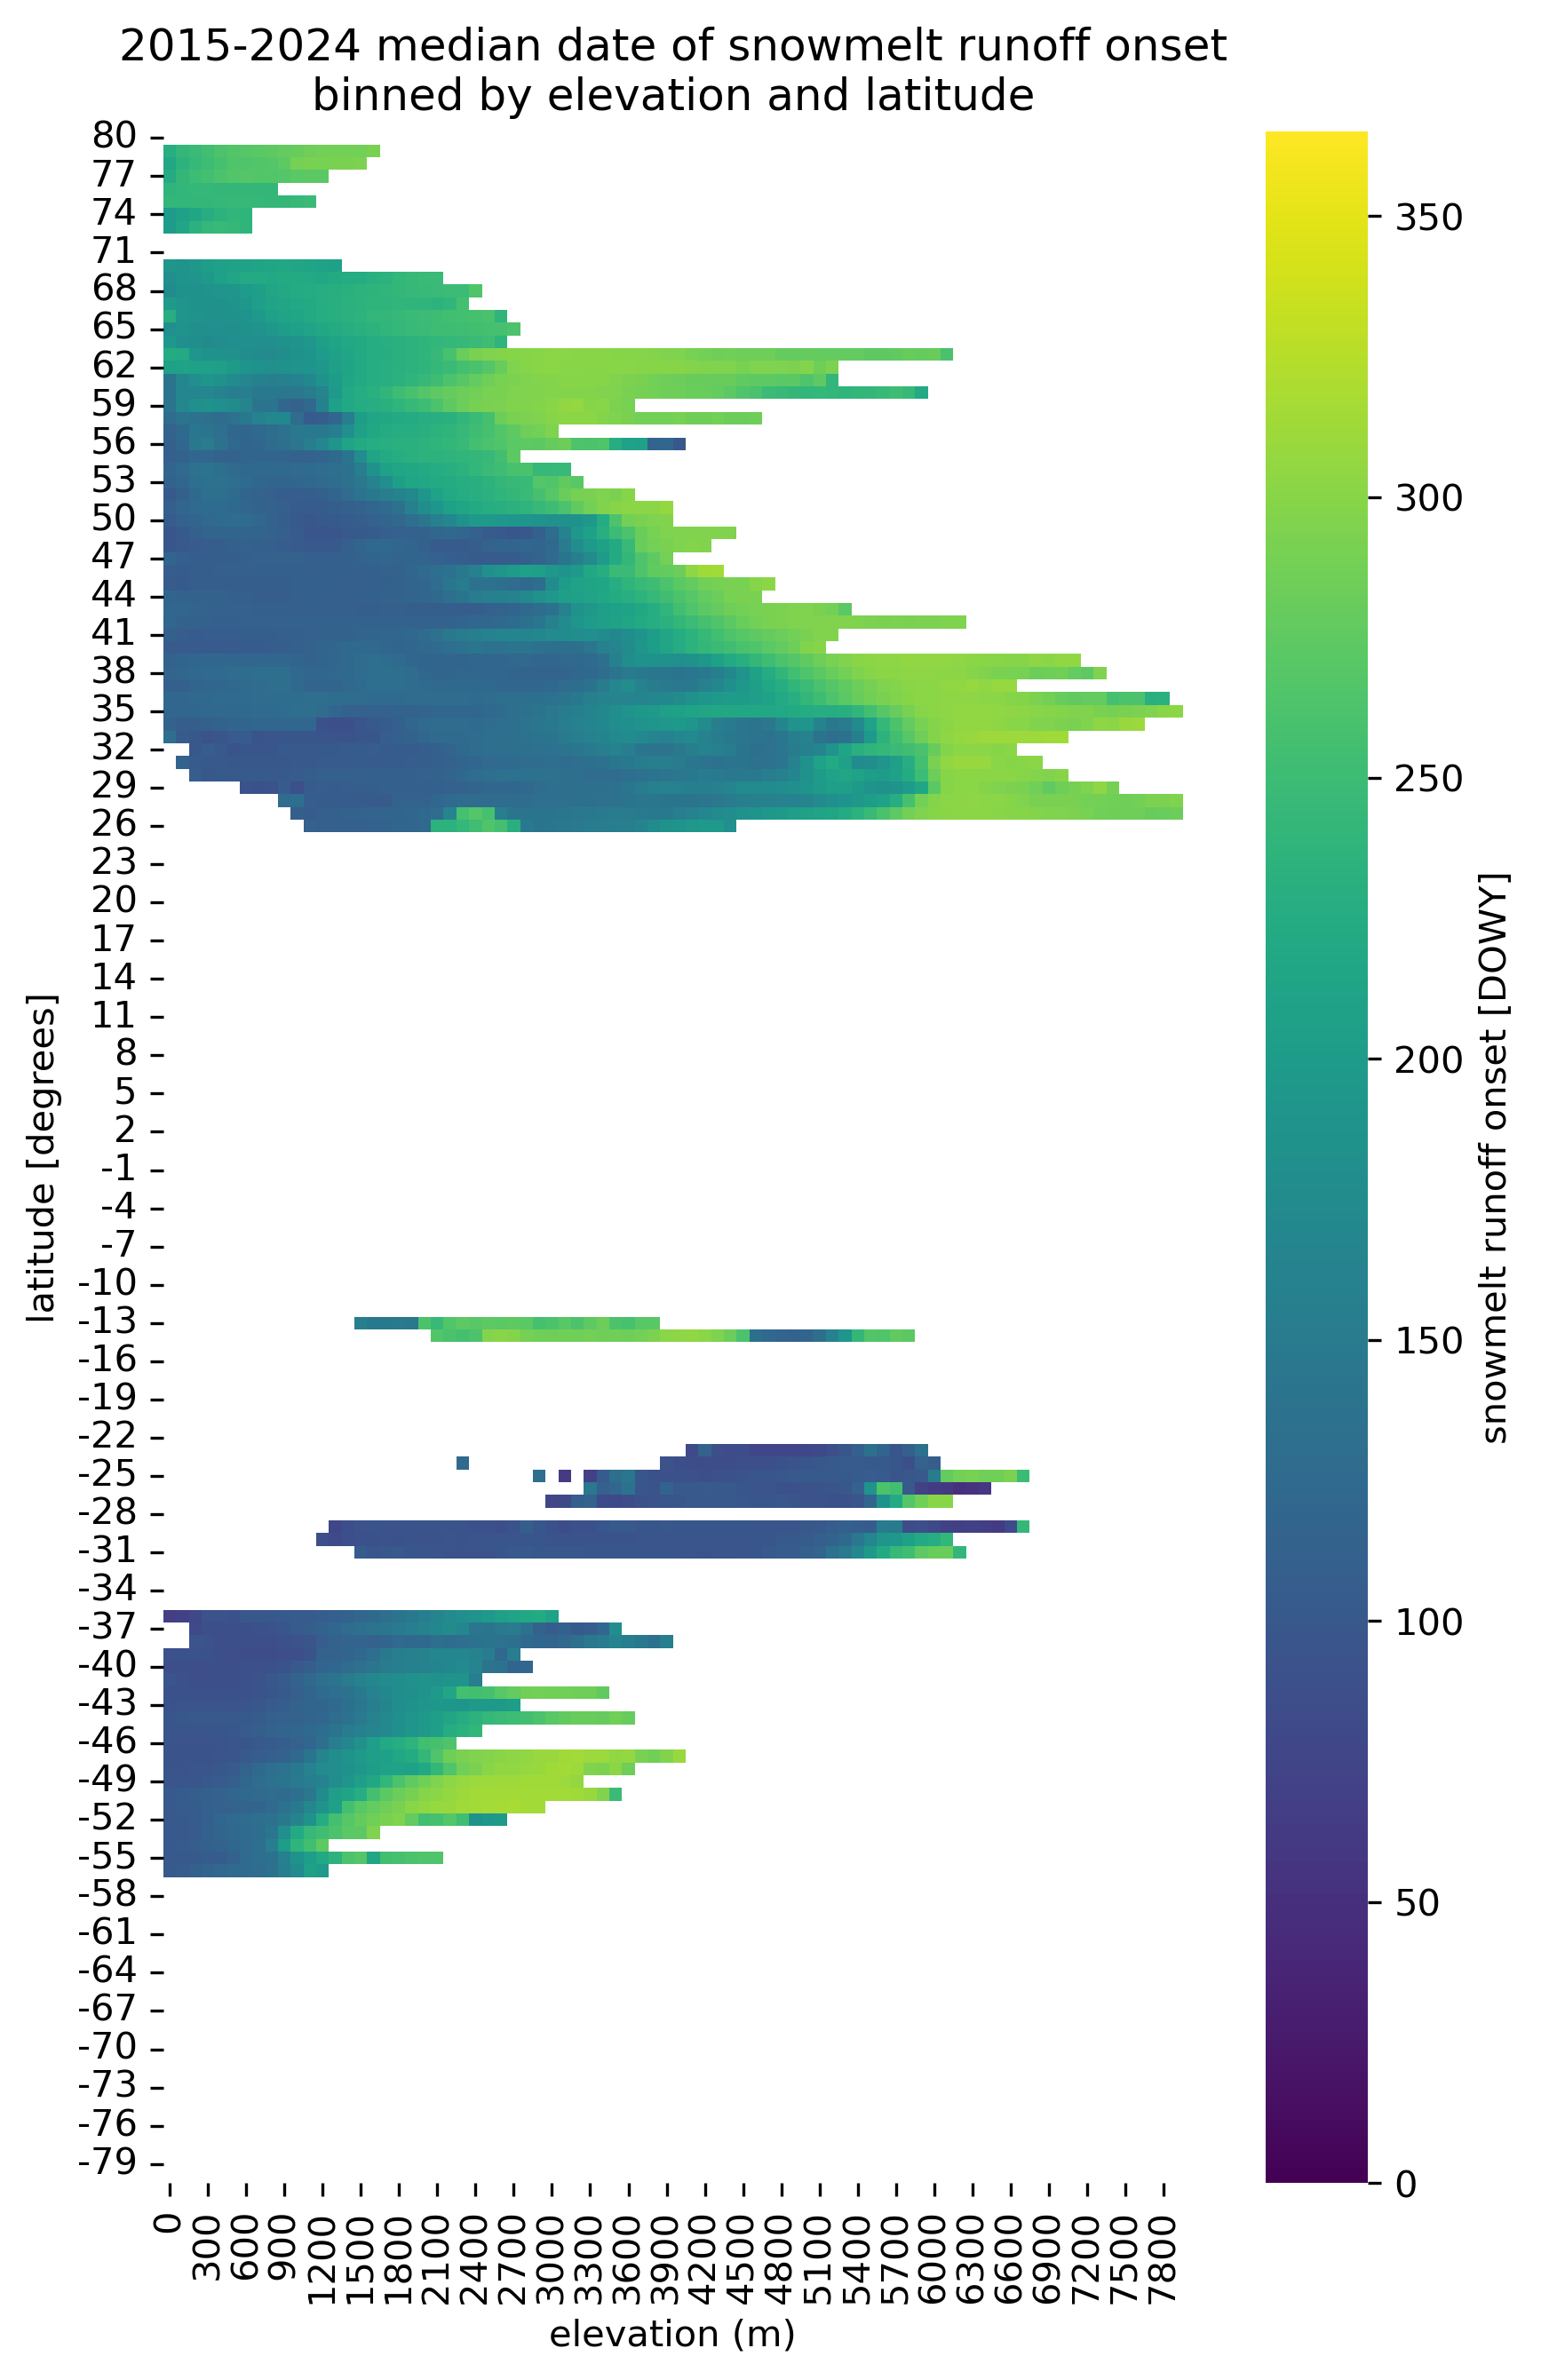

In [20]:
# Pivot the result DataFrame to create a 2D array suitable for heatmap
#pivot_df = result.pivot(index='lat_bin', columns='dem_bin', values='runoff_onset_median')


# Create the heatmap
f,ax=plt.subplots(figsize=(8,10),dpi=300)
sns.heatmap(runoff_onset_vs_lat_and_elev_df, square=True,ax=ax, cmap='viridis', cbar_kws={'label': 'snowmelt runoff onset [DOWY]'},
            vmin=0,vmax=365)

# Set labels and title
ax.set_xlabel('elevation (m)')
ax.set_ylabel('latitude [degrees]')
ax.set_title('2015-2024 median date of snowmelt runoff onset\nbinned by elevation and latitude')

# Rotate x-axis labels for better readability
#ax.set_ticks(rotation=45, ha='right')

#f.tight_layout()

## global analysis: 

## Code graveyard

In [ ]:
dfs = [pd.read_parquet(file,filesystem=azure_filesystem) for file in parquet_files]
dfs

all_tiles_results_df = pd.concat(dfs, ignore_index=True)
all_tiles_results_df